# 1 - Importing all the required modules and the functions.py file that contains our custom made functions

In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import getpass
import glob

import functions
import spectrogram_plotting_functions
import scipy.stats
importlib.reload(functions) #loads our custom made functions.py file
importlib.reload(spectrogram_plotting_functions)


<module 'spectrogram_plotting_functions' from 'c:\\Users\\Thomas\\Desktop\\cpl_analysis_naman\\spectrogram_plotting_functions.py'>

# 2 - Loading the data files

This code fetches the current 'user' by using getpass. Then it sets the basepath, loads the files and specifies the savepath. Note that the basepath, files and savepath need to be changed depending on where you have kept the files and where you want the results to be stored. In this case, I have set it up to be in a particular folder in my Dropbox account, which is stored locally.

In [13]:
#Fetch the current user
user= (getpass.getuser())
print("Hello", user)

#Set the basepath, savepath and load the data files
base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

Hello Thomas
['C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk1_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk3_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk5_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk6_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230610_dk1_BW_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230610_dk3_BW_noconte

In [22]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk1_nocontext.mat']
event_data_df=[]
shuffled_event_data_df=[]
events_codes_all = {}
before_data_power_df=pd.DataFrame(columns=['rat_id','task','channel_id','before_data_power','before_data_spec'])
scrambled_baseline_power_df=pd.DataFrame(columns=['rat_id','task','channel_id','before_data_power','before_data_spec'])
averaged_data=pd.DataFrame(columns=['rat_id','task','channel_id','average_power_spectrum'])
averaged_data_welch=pd.DataFrame(columns=['rat_id','task','channel_id','average_power_spectrum'])
random_baseline_data=[]
experiment_num=0
for file in files:
    #if 'dk6' in file:
        experiment_num+=1
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        print(date, rat_id, task)

        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)

        if 'Keyboard' in channels:
            events = f['Keyboard']
        elif 'keyboard' in channels:
            events = f['keyboard']
        elif 'memory' in channels:
            events = f['memory']
        elif 'Memory' in channels:
            events = f['Memory']

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = functions.generate_epochs_with_all_digs(events_codes, events_times)

        first_event = events_times[0]
        for channeli in channels:
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)

                data_before, time, baseline_mean, baseline_std=functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                
                normalized_data=functions.zscore_event_data(notch_filtered_data, baseline_mean, baseline_std)

                #normalized_data, time, data_before = functions.data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                
                # This makes a dataframe for calculating baseline power 
                bd_freq, bd_power = scipy.signal.welch(data_before,fs=2000.0, nperseg=512)
                #before_data_power=functions.calculate_power_1D(data_before)
                
                #before_data_power = np.sum(bd_power) * delta_f
                
                def band_powers(data, freqs):
                    delta_f = freqs[1] - freqs[0]

                    theta = np.where((freqs >= 4) & (freqs <= 12))
                    beta = np.where((freqs >= 12) & (freqs <= 30))
                    gamma = np.where((freqs >= 30) & (freqs <= 100))
                    total_power = np.sum(data)*delta_f
                    theta_power = np.sum(data[theta])*delta_f
                    beta_power = np.sum(data[beta])*delta_f
                    gamma_power = np.sum(data[gamma])*delta_f
                    return total_power, theta_power, beta_power, gamma_power
                
                before_data_power, baseline_theta_power, baseline_beta_power, baseline_gamma_power = band_powers(bd_power, bd_freq)
                before_data_row=pd.DataFrame({'rat_id':[rat_id],'task':[task],'channel_id':[channel_id],'before_data_power':[before_data_power],'before_data_spec':[bd_power],'beta_power':[baseline_beta_power],'theta_power':[baseline_theta_power],'gamma_power':[baseline_gamma_power]})
                before_data_power_df=pd.concat([before_data_power_df,before_data_row],ignore_index=True)
                
                scrambled_baseline_data=np.copy(data_before)
                #This makes a dataframe for calculating scrambled baseline power
                np.random.shuffle(scrambled_baseline_data)
                scrambled_baseline_freq, scrambled_baseline_power = scipy.signal.welch(scrambled_baseline_data,fs=2000.0, nperseg=512)
                scrambled_baseline_total_power, scrambled_baseline_theta_power, scrambled_baseline_beta_power, scrambled_baseline_gamma_power = band_powers(scrambled_baseline_power, scrambled_baseline_freq)
                scrambled_baseline_row = pd.DataFrame({'rat_id':[rat_id],'task':[task],'channel_id':[channel_id],
                                                       'before_data_power':[scrambled_baseline_total_power],'before_data_spec':[scrambled_baseline_power],
                                                       'beta_power':[scrambled_baseline_beta_power],'theta_power':[scrambled_baseline_theta_power],
                                                       'gamma_power':[scrambled_baseline_gamma_power]})
                scrambled_baseline_power_df=pd.concat([scrambled_baseline_power_df,scrambled_baseline_row],ignore_index=True)
                
                
                ##Calculate the power spectrum around events for each trial

                total = normalized_data
                compiled_data = []
                power_spectra = []
                
                compiled_data_welch = []
                power_spectra_welch = []

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    if epochi.shape[0] > 1:
                        correct_dig=epochi[epochi[:,1]==49]
                        dig_timestamp = correct_dig[0, 0] #Extract the first CORRECT dig timestamp
                    else:
                        continue
                    time_to_dig = dig_timestamp - door_timestamp
                    # dig_type = epochi[1, 1]
                    # print(dig_type)
                    # dig_timestamp = epochi[1, 0]
                    # print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_complete_trial = functions.extract_complete_trial_data(total, time, door_timestamp, dig_timestamp, sampling_rate)
                    
                    #Here we will extract and store the events data
                    data_door_before,data_door_after=functions.extract_door_data(total, time, door_timestamp, sampling_rate)    
                    data_dig_before, data_dig_after=functions.extract_dig_data(total,time, dig_timestamp, sampling_rate)
                    
                    event_data_list=[data_door_before,data_door_after,data_dig_before,data_dig_after]
                    #[functions.zscore_event_data(event_data, baseline_std) for event_data in event_data_list]
                    event_time=np.linspace(0,2,2*sampling_rate)
                    event_row=[]
                    shuffled_event_row=[]

                    event_row.extend([experiment_num, rat_id, task, channeli,before_data_power, baseline_beta_power, baseline_theta_power, baseline_gamma_power, i, time_to_dig])
                    shuffled_event_row.extend([experiment_num, rat_id, task, channeli,scrambled_baseline_total_power, scrambled_baseline_beta_power, scrambled_baseline_theta_power, scrambled_baseline_gamma_power, i, time_to_dig])
                    
                    for event_data in event_data_list:
                        faxis, Sxx_event = scipy.signal.welch(event_data,sampling_rate,nperseg=1024)
                        event_row.append(np.abs(Sxx_event))
                        total_power, theta_power, beta_power, gamma_power = band_powers(Sxx_event, faxis)
                        event_row.extend([total_power,beta_power, theta_power, gamma_power])
                        
                        #shuffled data
                        shuffled_data=np.copy(event_data)
                        np.random.shuffle(shuffled_data)
                        faxis_shuffled, Sxx_event_shuffled = scipy.signal.welch(shuffled_data,sampling_rate,nperseg=1024)
                        total_power_shuffled, theta_power_shuffled, beta_power_shuffled, gamma_power_shuffled = band_powers(Sxx_event_shuffled, faxis_shuffled)
                        shuffled_event_row.append(np.abs(Sxx_event_shuffled))
                        shuffled_event_row.extend([total_power_shuffled,beta_power_shuffled, theta_power_shuffled, gamma_power_shuffled])
                        

                    event_data_df.append(event_row)
                    shuffled_event_data_df.append(shuffled_event_row)


event_data_compiled_df = pd.DataFrame(event_data_df, columns=['experiment_num','rat_id','task','channel_id','baseline total','baseline beta','baseline theta','baseline gamma','epoch','time to correct dig','door before','door before total','door before beta','door before theta','door before gamma', 'door after','door after total','door after beta','door after theta','door after gamma','dig before','dig before total','dig before beta','dig before theta','dig before gamma','dig after','dig after total','dig after beta','dig after theta','dig after gamma'])
shuffled_event_data_compiled_df=pd.DataFrame(shuffled_event_data_df, columns=['experiment_num','rat_id','task','channel_id','baseline total','baseline beta','baseline theta','baseline gamma','epoch','time to correct dig','door before','door before total','door before beta','door before theta','door before gamma', 'door after','door after total','door after beta','door after theta','door after gamma','dig before','dig before total','dig before beta','dig before theta','dig before gamma','dig after','dig after total','dig after beta','dig after theta','dig after gamma'])

C:\Users\Thomas\Dropbox\CPLab\all_data_mat\20230529_dk1_nocontext.mat
20230529 dk1 nocontext
20230529 dk1 nocontext
['Keyboard', 'LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']
(1516022,) (1516022,) 2000
notch filter applied
normalizing data


C:\Users\Thomas\AppData\Local\Temp\ipykernel_46044\2800230117.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  before_data_power_df=pd.concat([before_data_power_df,before_data_row],ignore_index=True)
C:\Users\Thomas\AppData\Local\Temp\ipykernel_46044\2800230117.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scrambled_baseline_power_df=pd.concat([scrambled_baseline_power_df,scrambled_baseline_row],ignore_index=True)


4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
(1516022,) (1516022,) 2000
notch filter applied
normalizing data
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
(1516022,) (1516022,) 2000
notch filter applied
normalizing data
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
(1516022,) (1516022,) 2000
notch filter applied
normalizing data
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
4000 4000
(1516

In [26]:
aon_bwcontext = event_data_compiled_df[(event_data_compiled_df['task']=='BWcontext') & (event_data_compiled_df['channel_id'].str.contains('AON'))]
aon_bwnocontext=event_data_compiled_df[(event_data_compiled_df['task']=='BWnocontext') & (event_data_compiled_df['channel_id'].str.contains('AON'))]

[0.729995   7.46430075] [0.86     8.209995]


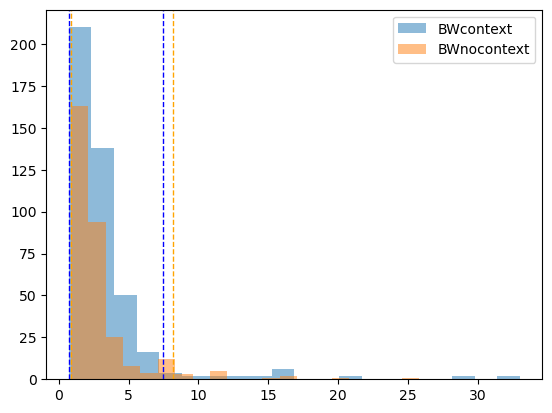

In [37]:
plt.hist(aon_bwcontext['time to correct dig'], bins=20, alpha=0.5, label='BWcontext')
plt.hist(aon_bwnocontext['time to correct dig'], bins=20, alpha=0.5, label='BWnocontext')
bwcontext_95 = np.percentile(aon_bwcontext['time to correct dig'], [0, 95])
bwnocontext_95 = np.percentile(aon_bwnocontext['time to correct dig'], [0, 95])
print(bwcontext_95, bwnocontext_95)

plt.axvline(bwcontext_95[0], color='blue', linestyle='dashed', linewidth=1)
plt.axvline(bwcontext_95[1], color='blue', linestyle='dashed', linewidth=1)
plt.axvline(bwnocontext_95[0], color='orange', linestyle='dashed', linewidth=1)
plt.axvline(bwnocontext_95[1], color='orange', linestyle='dashed', linewidth=1)

plt.legend()
plt.show()

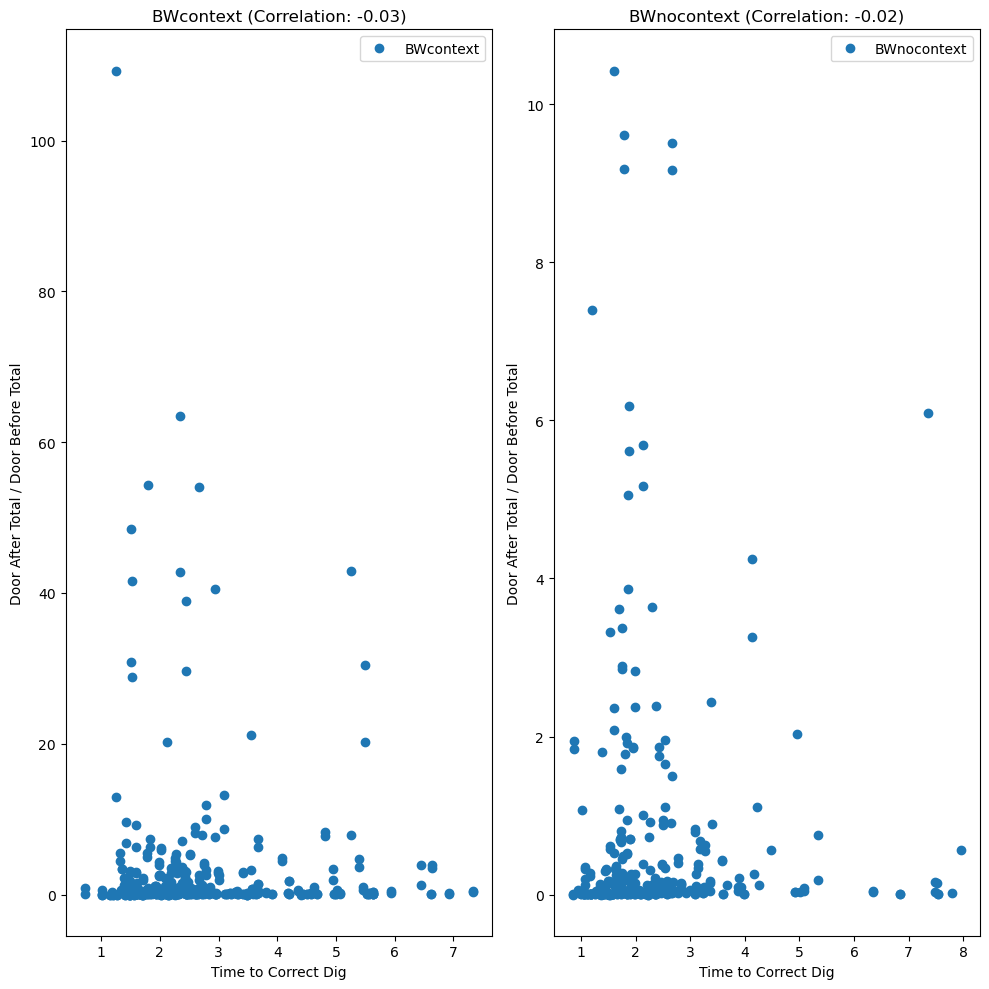

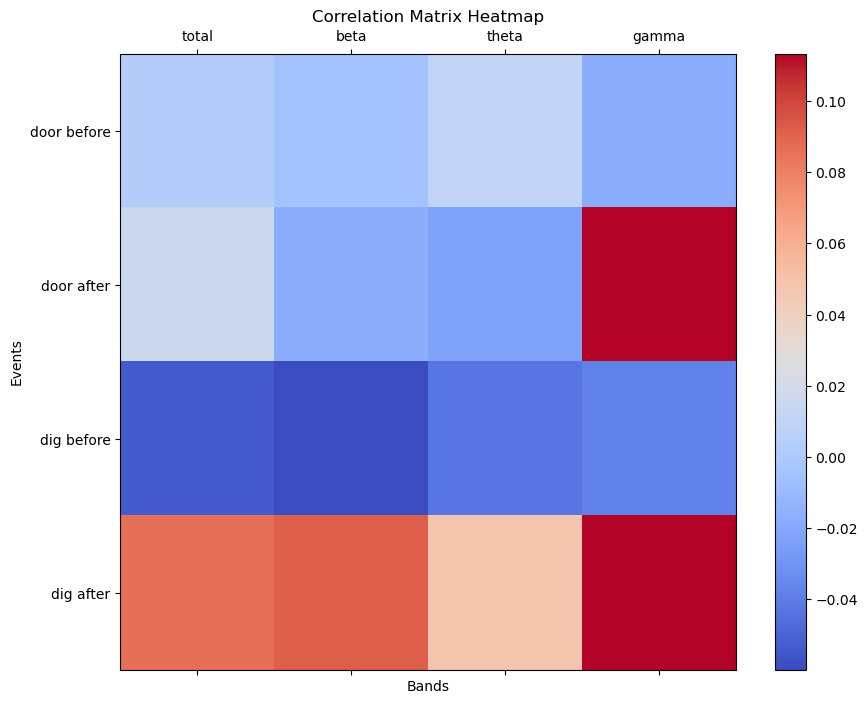

In [41]:
fig,axs=plt.subplots(1,2,figsize=(10,10))
axs=axs.flatten()
aon_bwcontext = aon_bwcontext[aon_bwcontext['time to correct dig'] < 8]
aon_bwnocontext = aon_bwnocontext[aon_bwnocontext['time to correct dig'] < 8]

axs[0].plot(aon_bwcontext['time to correct dig'],aon_bwcontext['door after beta'],'o',label='BWcontext')
# Calculate the correlation
correlation = aon_bwcontext['time to correct dig'].corr(aon_bwcontext['door after beta'])

# Plot the correlation
axs[0].set_title(f'BWcontext (Correlation: {correlation:.2f})')
axs[0].set_xlabel('Time to Correct Dig')
axs[0].set_ylabel('Door After Total / Door Before Total')
axs[0].legend()


# Repeat for BWnocontext
correlation_nocontext = aon_bwnocontext['time to correct dig'].corr(aon_bwnocontext['door after beta'])
axs[1].plot(aon_bwnocontext['time to correct dig'],aon_bwnocontext['door after beta'],'o',label='BWnocontext')
axs[1].set_title(f'BWnocontext (Correlation: {correlation_nocontext:.2f})')
axs[1].set_xlabel('Time to Correct Dig')
axs[1].set_ylabel('Door After Total / Door Before Total')
axs[1].legend()

plt.tight_layout()
plt.show()

events_list=['door before','door after','dig before','dig after']
bands=['total','beta','theta','gamma']

correlation_matrix = np.zeros((len(events_list), len(bands)))

for i, event in enumerate(events_list):
    for j, band in enumerate(bands):
        column_name = f'{event} {band}'
        correlation_matrix[i, j] = aon_bwnocontext['time to correct dig'].corr(aon_bwnocontext[column_name])

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(bands)))
ax.set_yticks(np.arange(len(events_list)))
ax.set_xticklabels(bands)
ax.set_yticklabels(events_list)

plt.xlabel('Bands')
plt.ylabel('Events')
plt.title('Correlation Matrix Heatmap')
plt.show()